#Import Dependencies

In [ ]:
try:
  import mesa
except:
  !pip install mesa==1.1
import pandas as pd
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.8 MB/s eta 0:00:00


#Generate Data

In [ ]:
import pandas as pd
import numpy as np



# Parameter simulasi
total_agents = 100  # Total jumlah agen
proportion_not_vaccinated = 0.6  # Proporsi agen sehat tidak divaksinasi
proportion_vaccinated = 0.2      # Proporsi agen sehat divaksinasi
proportion_infected = 0.1        # Proporsi agen terinfeksi
proportion_recovered = 0.1       # Proporsi agen sembuh

# Hitung jumlah agen per kategori
num_not_vaccinated = int(proportion_not_vaccinated * total_agents)
num_vaccinated = int(proportion_vaccinated * total_agents)
num_infected = int(proportion_infected * total_agents)
num_recovered = int(proportion_recovered * total_agents)

# Hitung total agen, memastikan jumlah agen sembuh tidak melebihi total
total_agents = num_not_vaccinated + num_vaccinated + num_infected + num_recovered

# Buat ID agen
ids = np.arange(1, total_agents + 1)

# Tentukan status agen
statuses = (
    ["Sehat (Tidak Divaksinasi)"] * num_not_vaccinated +
    ["Sehat (Divaksinasi)"] * num_vaccinated +
    ["Terinfeksi"] * num_infected +
    ["Sembuh"] * num_recovered  # Menambahkan agen sembuh
)
np.random.shuffle(statuses)

# Buat imunitas berdasarkan status
immunities = []
for status in statuses:
    if status == "Sehat (Tidak Divaksinasi)":
        immunities.append(np.random.random())  # Nilai random antara 0.0 hingga 1.0
    elif status == "Sehat (Divaksinasi)":
        immunities.append(np.random.uniform(0.7, 0.9))
    elif status == "Terinfeksi":
        immunities.append(np.random.uniform(0.0, 0.2))  # Imunitas rendah saat terinfeksi
    elif status == "Sembuh":
        immunities.append(np.random.uniform(0.7, 1.0))  # Imunitas tinggi setelah sembuh

# Buat posisi acak (x, y)
positions = [(np.random.randint(0, 20), np.random.randint(0, 20)) for _ in range(total_agents)]

# Pisahkan posisi ke dalam kolom X dan Y
positions_x = [pos[0] for pos in positions]
positions_y = [pos[1] for pos in positions]

# Buat radius jangkauan
radius_range = 1

# Buat waktu terinfeksi untuk agen yang terinfeksi
infection_times = [np.random.randint(1, 15) if status == "Terinfeksi" else np.nan for status in statuses]

# Mengganti kolom status dengan label numerik
label_map = {
    "Sehat (Tidak Divaksinasi)": 0,
    "Sehat (Divaksinasi)": 1,
    "Terinfeksi": 2,
    "Sembuh": 3
}

# Label numerik berdasarkan status
labels = [label_map[status] for status in statuses]

# Buat DataFrame
data_agen = pd.DataFrame({
    "ID": ids,
    "Status": labels,
    "Imunitas": immunities,
    "Posisi X": positions_x,
    "Posisi Y": positions_y,
    "Radius Jangkauan": radius_range,
    "Waktu Terinfeksi": infection_times
})

# Menampilkan seluruh kolom dan baris
pd.set_option('display.max_columns', None)  # Menampilkan semua kolom
pd.set_option('display.max_rows', None)  # Menampilkan semua baris
pd.set_option('display.width', None)  # Menyesuaikan lebar tampilan
pd.set_option('display.max_colwidth', None)  # Menampilkan kolom dengan panjang karakter penuh

# Menampilkan data
print(data_agen)


     ID  Status  Imunitas  Posisi X  Posisi Y  Radius Jangkauan  Waktu Terinfeksi
0     1       3  0.897651         7         5                 1               NaN
1     2       1  0.747307        14         5                 1               NaN
2     3       0  0.791862        10        10                 1               NaN
3     4       0  0.232135         9        16                 1               NaN
4     5       1  0.821173         8         7                 1               NaN
5     6       2  0.084851         6         4                 1               8.0
6     7       0  0.473920        12        18                 1               NaN
7     8       1  0.824838         0         3                 1               NaN
8     9       1  0.758003        14        10                 1               NaN
9    10       0  0.248328         7         0                 1               NaN
10   11       0  0.192306        14         9                 1               NaN
11   12       0 

#Visualisasi Awal

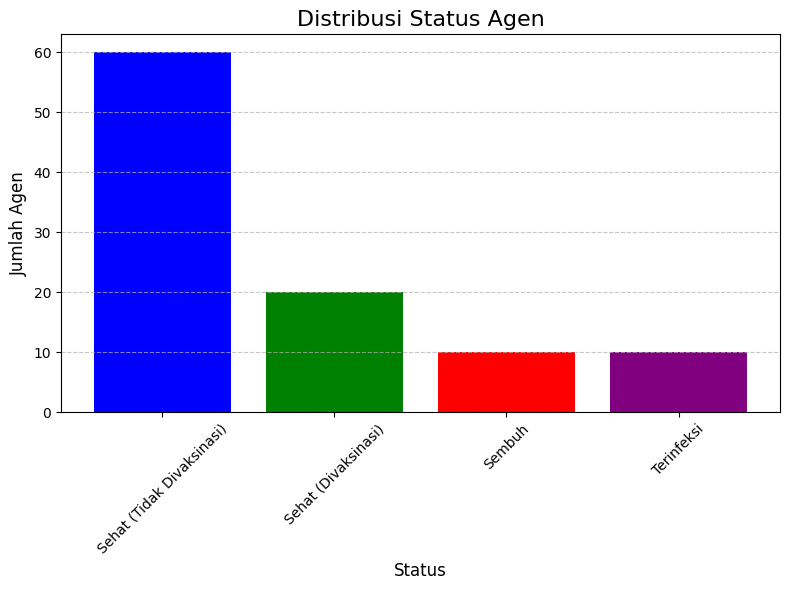

In [ ]:
import matplotlib.pyplot as plt

# Hitung jumlah agen per status
status_counts = data_agen["Status"].value_counts()

# Mapping label status numerik ke nama kategori
status_labels = {
    0: "Sehat (Tidak Divaksinasi)",
    1: "Sehat (Divaksinasi)",
    2: "Terinfeksi",
    3: "Sembuh"
}

# Label kategori berdasarkan mapping
categories = [status_labels[label] for label in status_counts.index]

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, status_counts, color=["blue", "green", "red", "purple"])
plt.title("Distribusi Status Agen", fontsize=16)
plt.xlabel("Status", fontsize=12)
plt.ylabel("Jumlah Agen", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


#Kelas Agen

In [ ]:
import random

class Agent(Agent):
    def __init__(self, agent_id, status, immunity, position, radius, infection_time, vaccinated=False):
        self.agent_id = agent_id
        self.status = status  # 0: Sehat, 1: Sembuh, 2: Terinfeksi, 3: Sembuh (vaksin)
        self.immunity = immunity
        self.position = position  # Tuple (x, y)
        self.radius = radius  # Radius interaksi
        self.infection_time = infection_time  # Waktu tersisa untuk infeksi
        self.infected_duration = 0  # Durasi infeksi
        self.vaccinated = vaccinated  # Menandakan apakah agen ini divaksinasi

    def move(self, grid_size):
        """
        Pindahkan agen secara acak ke tetangga terdekat (±1 langkah dalam grid).
        Hanya kolom X dan Y yang berubah.
        """
        x, y = self.position
        x_max, y_max = grid_size

        # Pilih pergeseran acak (-1, 0, 1) untuk X dan Y
        dx = random.choice([0, 1])  # Hanya tambah 0 atau 1
        dy = random.choice([0, 1])  # Hanya tambah 0 atau 1

        # Pastikan tetap berada dalam batas grid
        new_x = min(max(0, x + dx), x_max - 1)
        new_y = min(max(0, y + dy), y_max - 1)

        self.position = (new_x, new_y)

    def infect(self, other):
        """
        Upaya menularkan penyakit ke agen lain berdasarkan jarak dan imunisasi.
        Agen vaksin memiliki kemungkinan tertular hanya 40%.
        """
        if self.status == 2 and other.status == 0:  # Hanya agen sehat yang dapat terinfeksi
            distance = ((self.position[0] - other.position[0]) ** 2 +
                        (self.position[1] - other.position[1]) ** 2) ** 0.5
            if distance <= self.radius:
                # Jika agen divaksinasi, kemungkinan tertular hanya 40% (Menurut The Centers Disease Control and Prevention)
                infection_probability = 0.4 if other.vaccinated else 1 - other.immunity
                if random.random() < infection_probability:
                    other.status = 2  # Infeksi berhasil
                    other.infected_duration = self.infection_time

    def update_status(self):
        """
        Perbarui status agen berdasarkan waktu infeksi.
        Agen yang terinfeksi (status 2) akan langsung berubah menjadi agen sembuh (status 3)
        setelah durasi infeksi habis.
        """
        if self.status == 2:  # Agen terinfeksi
            self.infected_duration -= 1
            if self.infected_duration <= 0:
                self.status = 3  # Agen sembuh (baik yang divaksinasi atau tidak)
                self.immunity = min(self.immunity + 0.2, 1.0)  # Tambah kekebalan bagi agen tidak vaksin


#Flu Spread Model

In [ ]:
import random
import pandas as pd

class FluSpreadModel(Model):
    def __init__(self, agents, grid_size):
        self.agents = agents
        self.grid_size = grid_size
        self.history = []  # Menyimpan riwayat simulasi

    def step(self):
        for agent in self.agents:
            agent.move(self.grid_size)  # Pindahkan agen
            for other in self.agents:
                if agent != other:
                    agent.infect(other)  # Upaya menularkan penyakit
            agent.update_status()  # Perbarui status agen

    def run(self, steps):
        # Simpan kondisi awal
        self.save_state(0)

        for step in range(1, steps + 1):
            self.step()
            self.save_state(step)

    def save_state(self, step):
        """
        Simpan status agen saat ini ke riwayat simulasi.
        """
        for agent in self.agents:
            self.history.append({
                'Step': step,
                'ID': agent.agent_id,
                'Status': agent.status,
                'Imunitas': agent.immunity,
                'Posisi X': agent.position[0],
                'Posisi Y': agent.position[1],
            })

    def get_history_dataframe(self):
        """
        Konversi riwayat simulasi menjadi DataFrame.
        """
        return pd.DataFrame(self.history)

    def get_status_counts(self):
        """
        Menghitung jumlah agen berdasarkan statusnya.
        """
        sehat = sum(agent.status == 0 for agent in self.agents)  # Agen Sehat
        vaksin = sum(agent.status == 1 for agent in self.agents)  # Agen Sembuh (Vaksin)
        terinfeksi = sum(agent.status == 2 for agent in self.agents)  # Agen Terinfeksi
        sembuh = sum(agent.status == 3 for agent in self.agents)  # Agen Sembuh
        return {"Sehat": sehat, "Vaksin": vaksin, "Terinfeksi": terinfeksi, "Sembuh": sembuh}

    def get_average_immunity(self):
        """
        Menghitung rata-rata imunitas agen.
        """
        total_immunity = sum(agent.immunity for agent in self.agents)
        return total_immunity / len(self.agents) if len(self.agents) > 0 else 0



#Run Model and Result

In [ ]:
import pandas as pd

# Membaca data dan menginisialisasi agen
agents = []
for _, row in data_agen.iterrows():
    agent = Agent(
        agent_id=row['ID'],
        status=row['Status'],
        immunity=row['Imunitas'],
        position=(row['Posisi X'], row['Posisi Y']),
        radius=row['Radius Jangkauan'],
        infection_time=row['Waktu Terinfeksi'],
    )
    agents.append(agent)

# Inisialisasi model
grid_size = (20, 20)  # Ukuran grid
model = FluSpreadModel(agents, grid_size)

# Menjalankan simulasi untuk 30 langkah
model.run(steps=30)

# Mendapatkan hasil simulasi sebagai DataFrame
simulation_results = model.get_history_dataframe()

# Memisahkan hasil berdasarkan langkah (step)
step_dfs = {}

for step in range(31):  # Melihat kondisi untuk langkah 0 sampai 30
    step_state = simulation_results[simulation_results['Step'] == step]

    # Menyimpan setiap langkah ke dalam dictionary dengan nama step sebagai key
    step_dfs[step] = step_state

# Menampilkan setiap DataFrame untuk setiap step dan menghitung status agen
for step, step_state in step_dfs.items():
    print(f"Step {step} state:")

    # Tampilkan status agen pada langkah ini
    print(step_state.to_string(index=False))  # Tampilkan tabel tanpa index

    # Menghitung jumlah agen berdasarkan status
    status_counts = step_state['Status'].value_counts()

    # Menampilkan jumlah agen berdasarkan status
    print("Jumlah Agen berdasarkan Status:")
    print(f"Sehat Tidak Vaksin: {status_counts.get(0, 0)}")  # Status 0 untuk Sehat Tidak Vaksin
    print(f"Sehat Vaksin: {status_counts.get(1, 0)}")  # Status 1 untuk Sehat Vaksin
    print(f"Terinfeksi: {status_counts.get(2, 0)}")  # Status 2 untuk Terinfeksi
    print(f"Sembuh: {status_counts.get(3, 0)}")  # Status 3 untuk Sembuh
    print()  # Memberikan jarak antar langkah


Step 0 state:
 Step    ID  Status  Imunitas  Posisi X  Posisi Y
    0   1.0     3.0  0.897651       7.0       5.0
    0   2.0     1.0  0.747307      14.0       5.0
    0   3.0     0.0  0.791862      10.0      10.0
    0   4.0     0.0  0.232135       9.0      16.0
    0   5.0     1.0  0.821173       8.0       7.0
    0   6.0     2.0  0.084851       6.0       4.0
    0   7.0     0.0  0.473920      12.0      18.0
    0   8.0     1.0  0.824838       0.0       3.0
    0   9.0     1.0  0.758003      14.0      10.0
    0  10.0     0.0  0.248328       7.0       0.0
    0  11.0     0.0  0.192306      14.0       9.0
    0  12.0     0.0  0.826815       3.0      14.0
    0  13.0     3.0  0.819822      17.0      13.0
    0  14.0     1.0  0.844689      13.0      19.0
    0  15.0     3.0  0.814913      14.0       7.0
    0  16.0     3.0  0.818932      14.0      17.0
    0  17.0     1.0  0.759361      18.0      16.0
    0  18.0     0.0  0.974358       9.0       5.0
    0  19.0     0.0  0.813304      1

#Visualization

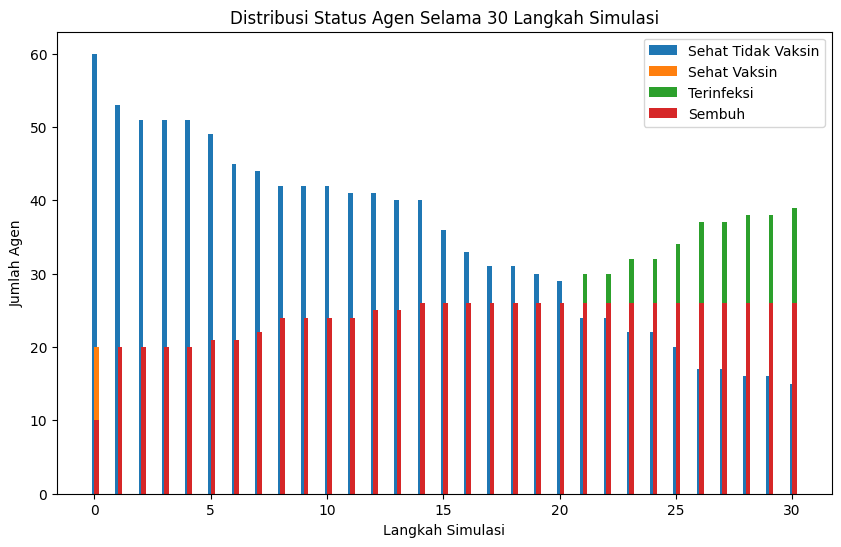

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dan menginisialisasi agen
agents = []
for _, row in data_agen.iterrows():
    agent = Agent(
        agent_id=row['ID'],
        status=row['Status'],
        immunity=row['Imunitas'],
        position=(row['Posisi X'], row['Posisi Y']),
        radius=row['Radius Jangkauan'],
        infection_time=row['Waktu Terinfeksi'],
    )
    agents.append(agent)

# Inisialisasi model
grid_size = (20, 20)  # Ukuran grid
model = FluSpreadModel(agents, grid_size)

# Menjalankan simulasi untuk 30 langkah
model.run(steps=30)

# Mendapatkan hasil simulasi sebagai DataFrame
simulation_results = model.get_history_dataframe()

# Memisahkan hasil berdasarkan langkah (step)
step_dfs = {}

# Menyimpan distribusi status setiap langkah
status_over_time = {0: [], 1: [], 2: [], 3: []}

for step in range(31):  # Melihat kondisi untuk langkah 0 sampai 30
    step_state = simulation_results[simulation_results['Step'] == step]

    # Menghitung jumlah agen berdasarkan status
    status_counts = step_state['Status'].value_counts()

    # Menyimpan jumlah agen berdasarkan status untuk setiap langkah
    status_over_time[0].append(status_counts.get(0, 0))  # Status 0 untuk Sehat Tidak Vaksin
    status_over_time[1].append(status_counts.get(1, 0))  # Status 1 untuk Sehat Vaksin
    status_over_time[2].append(status_counts.get(2, 0))  # Status 2 untuk Terinfeksi
    status_over_time[3].append(status_counts.get(3, 0))  # Status 3 untuk Sembuh

# Membuat diagram batang untuk distribusi status agen per langkah
plt.figure(figsize=(10, 6))
plt.bar(range(31), status_over_time[0], width=0.2, label='Sehat Tidak Vaksin', align='center')
plt.bar(range(31), status_over_time[1], width=0.2, label='Sehat Vaksin', align='edge')
plt.bar(range(31), status_over_time[2], width=0.2, label='Terinfeksi', align='edge')
plt.bar(range(31), status_over_time[3], width=0.2, label='Sembuh', align='edge')

plt.xlabel('Langkah Simulasi')
plt.ylabel('Jumlah Agen')
plt.title('Distribusi Status Agen Selama 30 Langkah Simulasi')
plt.legend()

# Menampilkan diagram batang
plt.show()


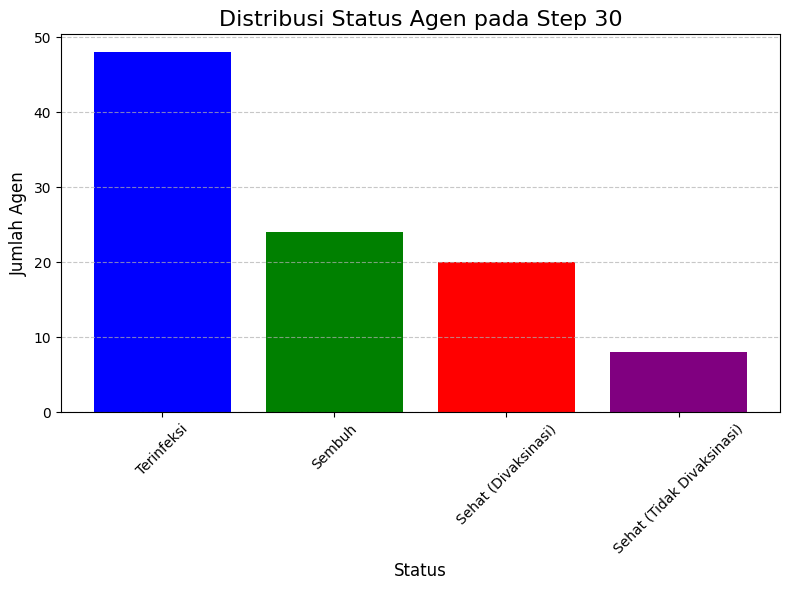

In [ ]:
import matplotlib.pyplot as plt

# Menyaring hasil simulasi pada step ke-30
step_30_state = simulation_results[simulation_results['Step'] == 30]

# Hitung jumlah agen per status pada step ke-30
status_counts_30 = step_30_state["Status"].value_counts()

# Mapping label status numerik ke nama kategori
status_labels = {
    0: "Sehat (Tidak Divaksinasi)",
    1: "Sehat (Divaksinasi)",
    2: "Terinfeksi",
    3: "Sembuh"
}

# Label kategori berdasarkan mapping
categories_30 = [status_labels[label] for label in status_counts_30.index]

# Plot bar chart untuk distribusi status agen pada step 30
plt.figure(figsize=(8, 6))
plt.bar(categories_30, status_counts_30, color=["blue", "green", "red", "purple"])
plt.title("Distribusi Status Agen pada Step 30", fontsize=16)
plt.xlabel("Status", fontsize=12)
plt.ylabel("Jumlah Agen", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


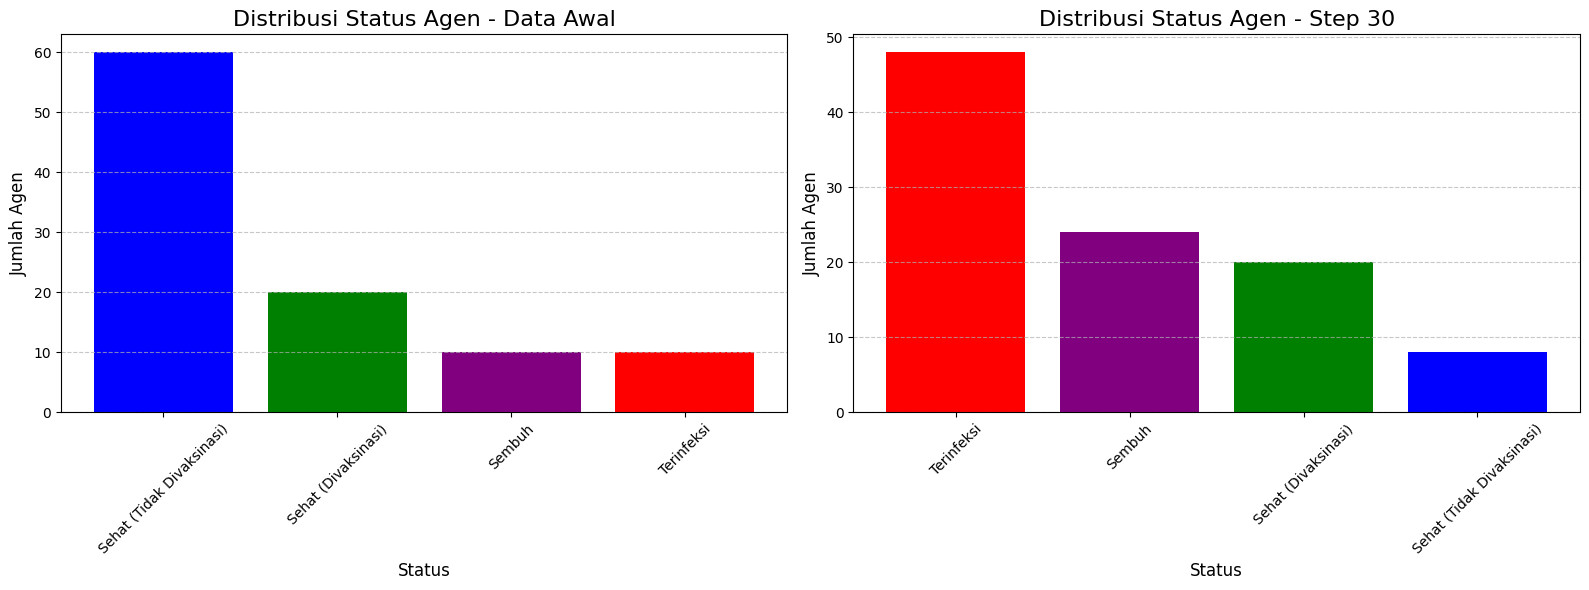

In [ ]:
import matplotlib.pyplot as plt

# Hitung jumlah agen per status pada data awal (sebelum simulasi)
status_counts_initial = data_agen["Status"].value_counts()

# Menyaring hasil simulasi pada step ke-30
step_30_state = simulation_results[simulation_results['Step'] == 30]
status_counts_30 = step_30_state["Status"].value_counts()

# Mapping label status numerik ke nama kategori
status_labels = {
    0: "Sehat (Tidak Divaksinasi)",
    1: "Sehat (Divaksinasi)",
    2: "Terinfeksi",
    3: "Sembuh"
}

# Warna yang konsisten untuk setiap status
status_colors = {
    0: "blue",   # Sehat (Tidak Divaksinasi)
    1: "green",  # Sehat (Divaksinasi)
    2: "red",    # Terinfeksi
    3: "purple"  # Sembuh
}

# Label kategori berdasarkan mapping
categories_initial = [status_labels[label] for label in status_counts_initial.index]
categories_30 = [status_labels[label] for label in status_counts_30.index]

# Plotting kedua grafik batang dalam satu tampilan (subplot)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grafik batang untuk data awal
axes[0].bar(categories_initial, status_counts_initial, color=[status_colors[label] for label in status_counts_initial.index])
axes[0].set_title("Distribusi Status Agen - Data Awal", fontsize=16)
axes[0].set_xlabel("Status", fontsize=12)
axes[0].set_ylabel("Jumlah Agen", fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Grafik batang untuk data pada step 30
axes[1].bar(categories_30, status_counts_30, color=[status_colors[label] for label in status_counts_30.index])
axes[1].set_title("Distribusi Status Agen - Step 30", fontsize=16)
axes[1].set_xlabel("Status", fontsize=12)
axes[1].set_ylabel("Jumlah Agen", fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Mengatur layout agar tidak ada overlap
plt.tight_layout()
plt.show()


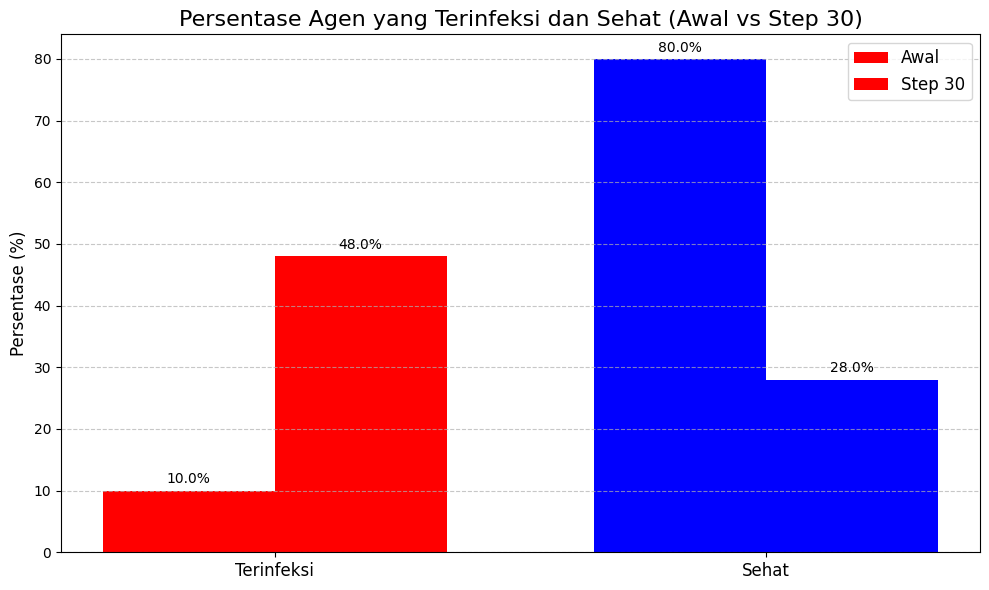

In [ ]:
import numpy as np

# Total agen pada awal simulasi dan step ke-30
total_agents_initial = len(data_agen)
total_agents_30 = len(step_30_state)

# Menghitung proporsi agen yang terinfeksi dan sehat
infected_initial = status_counts_initial.get(2, 0) / total_agents_initial * 100  # Persentase Terinfeksi Awal
infected_30 = status_counts_30.get(2, 0) / total_agents_30 * 100  # Persentase Terinfeksi Step 30

healthy_initial = (
    status_counts_initial.get(0, 0) + status_counts_initial.get(1, 0)
) / total_agents_initial * 100  # Persentase Sehat Awal
healthy_30 = (
    status_counts_30.get(0, 0) + status_counts_30.get(1, 0)
) / total_agents_30 * 100  # Persentase Sehat Step 30

# Data untuk visualisasi
categories = ["Terinfeksi", "Sehat"]
percentages_initial = [infected_initial, healthy_initial]
percentages_30 = [infected_30, healthy_30]

# Plotting grafik batang untuk persentase perubahan
x = np.arange(len(categories))  # Lokasi untuk kelompok kategori
width = 0.35  # Lebar batang

fig, ax = plt.subplots(figsize=(10, 6))

# Grafik batang untuk data awal
bars_initial = ax.bar(
    x - width / 2, percentages_initial, width, label="Awal", color=["red", "blue"]
)

# Grafik batang untuk data step 30
bars_30 = ax.bar(
    x + width / 2, percentages_30, width, label="Step 30", color=["red", "blue"]
)

# Menambahkan detail grafik
ax.set_title("Persentase Agen yang Terinfeksi dan Sehat (Awal vs Step 30)", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylabel("Persentase (%)", fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Menampilkan nilai pada setiap batang
for bars in [bars_initial, bars_30]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.1f}%",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # Jarak dari batang
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=10,
        )

plt.tight_layout()
plt.show()
